# Lab 8

## Gaining Early Insights from Textual Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Introducing the Dataset

In [2]:
# Load some data from UN debates
df = pd.read_csv('https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/un-general-debates/un-general-debates-blueprint.csv.gz')

# take a sample of 1000 rows for faster processing
df = df.sample(1000, random_state=42)
df.head()

,session,year,country,country_name,speaker,position,text
4456,54,1999,ZAF,South Africa,Thabo Mbeki,President,On behalf of our Government and\nin my capacit...
5603,61,2006,BRA,Brazil,Mr. Lula Da Silva,President,When I first \naddressed the Assembly from thi...
4685,56,2001,DZA,Algeria,Abdelaziz Belkhadem,Minister for Foreign Affairs,﻿This\nsession is taking place at a time when ...
1055,33,1978,NIC,Nicaragua,Quintana,NaN,﻿\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n388.\tIt ...
4812,56,2001,UKR,Ukraine,Anatoliy M. Zlenko,Minister for Foreign Affairs,﻿Allow me at the outset to\ncongratulate the P...


## Calculating Summary Statistics for Columns

In [3]:
# create a new column with the length of the text
df['length'] = df['text'].str.len()

# Describe gives summarry statistics (can pass in list-like of dtypes for filtering)
# use the transpose to get a better visual view
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
session,1000.0,NaN,NaN,NaN,48.95,12.888895,25.0,38.0,50.0,60.0,70.0
year,1000.0,NaN,NaN,NaN,1993.95,12.888895,1970.0,1983.0,1995.0,2005.0,2015.0
country,1000,195,FIN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_name,1000,195,Finland,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
speaker,998,946,Haile Weldensae,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
position,576,32,Minister for Foreign Affairs,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,1000,1000,﻿The current session of the United Nations Gen...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
length,1000.0,NaN,NaN,NaN,18274.424,7618.119264,3534.0,12426.5,16727.5,23001.25,54633.0


In [4]:
# use describe(include='O') to describe the object (in this case string) columns
df.describe(include='O').T

,count,unique,top,freq
country,1000,195,FIN,14
country_name,1000,195,Finland,14
speaker,998,946,Haile Weldensae,4
position,576,32,Minister for Foreign Affairs,226
text,1000,1000,﻿The current session of the United Nations Gen...,1


In [5]:
# use describe(include=np.number) to describe the numeric columns
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
session,1000.0,48.950,12.888895,25.0,38.0,50.0,60.00,70.0
year,1000.0,1993.950,12.888895,1970.0,1983.0,1995.0,2005.00,2015.0
length,1000.0,18274.424,7618.119264,3534.0,12426.5,16727.5,23001.25,54633.0


## Checking for Missing Data

In [6]:
# find the number of na values in each column
df.isna().sum()

session           0
year              0
country           0
country_name      0
speaker           2
position        424
text              0
length            0
dtype: int64

In [7]:
# fill the na values in the speaker column with 'unknown'
df['speaker'].fillna('unknown', inplace=True)

In [19]:
# find the number of speakers that contain the subword 'Bush'
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

speaker
Mr. George W Bush    1
George Bush          1
Name: count, dtype: int64

## Visualizing Developments over Time

Text(0, 0.5, 'Number of Countries')

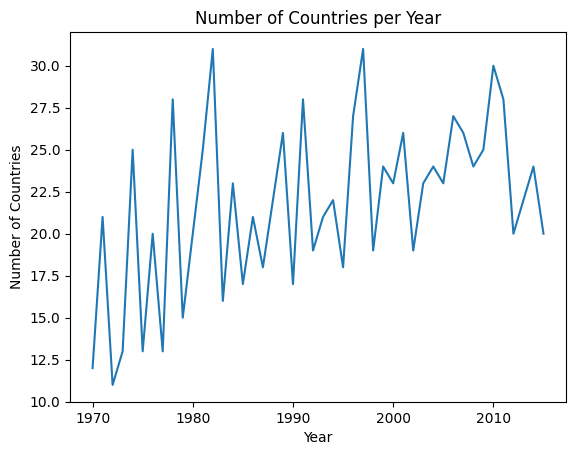

In [9]:
# Group by year and count the number of unique countries
countries_per_year = df.groupby('year')['country'].nunique()

# Plot the number of countries per year
countries_per_year.plot(kind='line')

# Setting the titles and labels
plt.title('Number of Countries per Year')
plt.xlabel('Year')
plt.ylabel('Number of Countries')

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='year'>

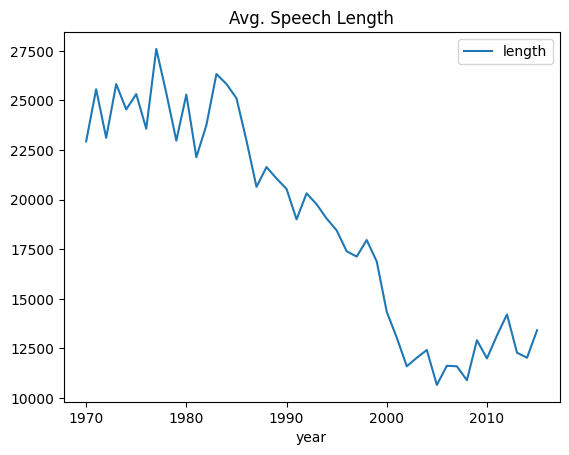

In [10]:
# Can use groupby objects to take advantage of built in aggregation function
df.groupby('year').agg({'length': 'mean'}).plot(title="Avg. Speech Length")

## Building a Simple Text Preprocessing Pipeline

### Tokenization with Regular Expressions

In [11]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


Let's break down the regular expression [\w-]*\p{L}[\w-]*:

[\w-]* : This segment is looking for zero or more (*) occurrences of a "word" character (\w) or a hyphen (-). A "word" character in regex terms includes the set of [a-zA-Z0-9_]. So it will match any alphanumeric (letters and numbers) and underscore characters, as well as hyphens, in any quantity—including none.

\p{L} : This segment stands for any kind of letter from any language. \p{} is a Unicode property escape, and L stands for letter. It will match a single character that is a letter.

[\w-]* : This is the same as the first segment. It's looking for zero or more word characters or hyphens.

So, put all together, [\w-]*\p{L}[\w-]* will match any string that has at least one letter (from any language) that can be surrounded by any number (including zero) of alphanumeric characters, underscores, or hyphens. This pattern allows the letter to appear anywhere within the string.

In [12]:
def lower_text(text):
    return text.lower()

### Removing Stop Words

In [13]:
import nltk
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))

include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

### Processing a Pipeline with one Line of Code


In [15]:
to_lower_transformer = FunctionTransformer(lower_text)
tokenizer_transformer = FunctionTransformer(tokenize)
remove_stop_transformer = FunctionTransformer(remove_stop)

# Build the pipeline
pipeline_sk = Pipeline([
    ('lower_text', to_lower_transformer),
    ('tokenizer', tokenizer_transformer),
    ('remove_stop', remove_stop_transformer)
])

# Now you can fit and transform text with the pipeline
prepared_text = pipeline_sk.fit_transform('This is a sample text')
print(prepared_text)

['sample', 'text']


In [16]:
# We can now tokenize the text in our dataset using a single line of code
df['tokens'] = df['text'].apply(pipeline_sk.fit_transform)
df['num_tokens'] = df['tokens'].map(len)
df.head()

,session,year,country,country_name,speaker,position,text,length,tokens,num_tokens
4456,54,1999,ZAF,South Africa,Thabo Mbeki,President,On behalf of our Government and\nin my capacit...,14384,"[behalf, government, capacity, chair, non-alig...",1125
5603,61,2006,BRA,Brazil,Mr. Lula Da Silva,President,When I first \naddressed the Assembly from thi...,12120,"[first, addressed, assembly, rostrum, stressed...",1001
4685,56,2001,DZA,Algeria,Abdelaziz Belkhadem,Minister for Foreign Affairs,﻿This\nsession is taking place at a time when ...,13995,"[session, taking, place, time, new, internatio...",1154
1055,33,1978,NIC,Nicaragua,Quintana,NaN,﻿\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n388.\tIt ...,13973,"[pleasure, convey, behalf, government, behalf,...",1098
4812,56,2001,UKR,Ukraine,Anatoliy M. Zlenko,Minister for Foreign Affairs,﻿Allow me at the outset to\ncongratulate the P...,11672,"[allow, outset, congratulate, president, gener...",966


## Creating Word Clouds

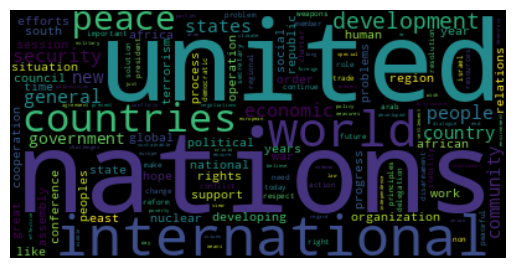

In [20]:
from wordcloud import WordCloud

# Compute TF-IDF values
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['text'])
feature_names = vectorizer.get_feature_names_out()

# Compute total TF-IDF weights for each term in a more memory-efficient way
weights = tfidf_matrix.sum(axis=0).A1

# Build a dictionary where keys are terms and values are weights
tfidf_dict = dict(zip(feature_names, weights))

# Create and display the word cloud
wordcloud = WordCloud().generate_from_frequencies(tfidf_dict)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Filtering our word clouds

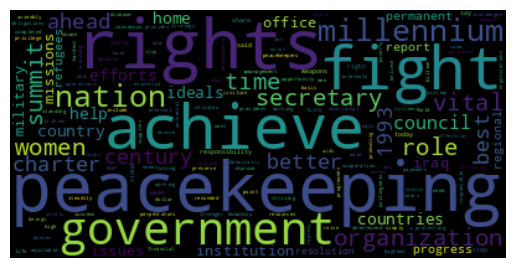

In [21]:
from wordcloud import WordCloud

# Compute TF-IDF values
vectorizer = TfidfVectorizer(stop_words='english')

# We can do some filtering here on what text we pass in
tfidf_matrix = vectorizer.fit_transform(df.loc[(df['year'] == 2000) & (df['country'] == 'USA')]['text'])

feature_names = vectorizer.get_feature_names_out()

# Compute total TF-IDF weights for each term in a more memory-efficient way
weights = tfidf_matrix.sum(axis=0).A1

# Build a dictionary where keys are terms and values are weights
tfidf_dict = dict(zip(feature_names, weights))

# We can filter out the popular terms from our dictionary like so
sorted_tfidf = sorted(tfidf_dict.items(), key=lambda x:x[1], reverse=True)

# There are more efficient ways to do this by filtering first but here our data set is small so it's fine
remove_top = 20
converted_dict = dict(sorted_tfidf[remove_top:])


# Create and display the word cloud
wordcloud = WordCloud().generate_from_frequencies(converted_dict)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Creating Frequency Timelines

In [22]:
# The Counter function takes an iterable (like a list or a string) as an argument and returns 
# a dictionary-like object where the keys are the unique elements in the iterable, 
# and the values are their respective counts.
# The elements in the iterable can be any hashable Python object.
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa.")

counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [23]:
# We want to count the occurunces of certain keywords
def count_keywords(tokens, keywords): 

    # Here we are taking advantage of list comprehensions
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [24]:
# This is a helper function that we can use to create a df using our count_keywords function
def count_keywords_by(df, by, keywords, column='tokens'):
    
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps in the index
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    
    return freq_df.groupby(by=by).sum().sort_values(by)

In [25]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom', 'war']

freq_df = count_keywords_by(df, by='year', keywords=keywords)

<Axes: xlabel='year'>

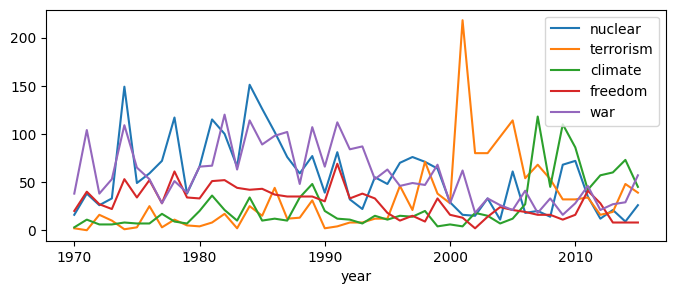

In [26]:
freq_df.plot(kind='line', figsize=(8, 3))

# Student Section

Create a filtered word cloud for Canadian (CAN) speeches from 2006 where you remove the top 10 words 

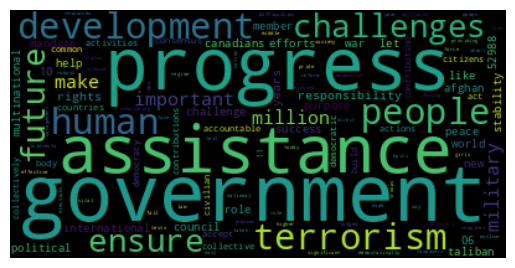

In [39]:
tfidf_matrix = vectorizer.fit_transform(df.loc[(df['year'] == 2006) 
                                               & (df['country'] == 'CAN')]['text'])
feature_names = vectorizer.get_feature_names_out()

weights = tfidf_matrix.sum(axis=0).A1

tfidf_dict = dict(zip(feature_names, weights))

sorted_tfidf = sorted(tfidf_dict.items(),
                      key=lambda x:x[1],
                      reverse=True)

remove_top = 10
converted_dict = dict(sorted_tfidf[remove_top:])

wordcloud = WordCloud().generate_from_frequencies(converted_dict)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Create a frequency timeline for the following keywords = ['war', 'peace', 'military', 'civilian']

<Axes: xlabel='year'>

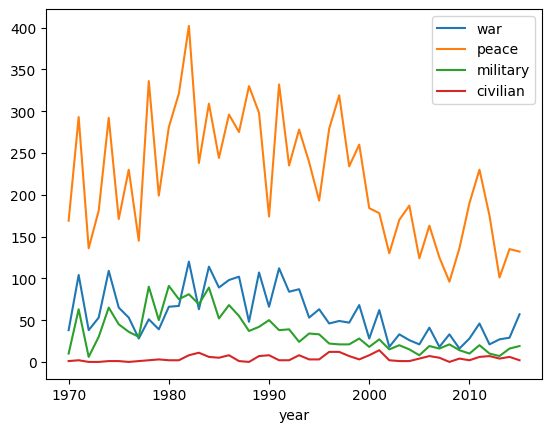

In [40]:
keywords = ['war', 'peace', 'military', 'civilian']

freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df.plot(kind='line')